# Task 2: Data Preparation for Change Point Analysis

This notebook prepares the Brent oil prices data for Bayesian change point detection using PyMC.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load and Prepare Data

In [25]:
# Load the Brent oil prices data
def parse_date(date_str):
    """Parse dates in different formats"""
    try:
        if '-' in date_str:
            return pd.to_datetime(date_str, format='%d-%b-%y')
        else:
            return pd.to_datetime(date_str, format='%b %d, %Y')
    except:
        return pd.NaT

# Load data
df = pd.read_csv('../../data/raw/BrentOilPrices.csv')
df['Date'] = df['Date'].apply(parse_date)
df = df.dropna().reset_index(drop=True)
df = df.sort_values('Date').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Price range: ${df['Price'].min():.2f} to ${df['Price'].max():.2f}")
df.head()

Dataset shape: (9011, 2)
Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Price range: $9.10 to $143.95


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## 2. Calculate Log Returns

Log Returns Statistics:
count    9010.000000
mean        0.000179
std         0.025532
min        -0.643699
25%        -0.011154
50%         0.000402
75%         0.012127
max         0.412023
Name: log_returns, dtype: float64


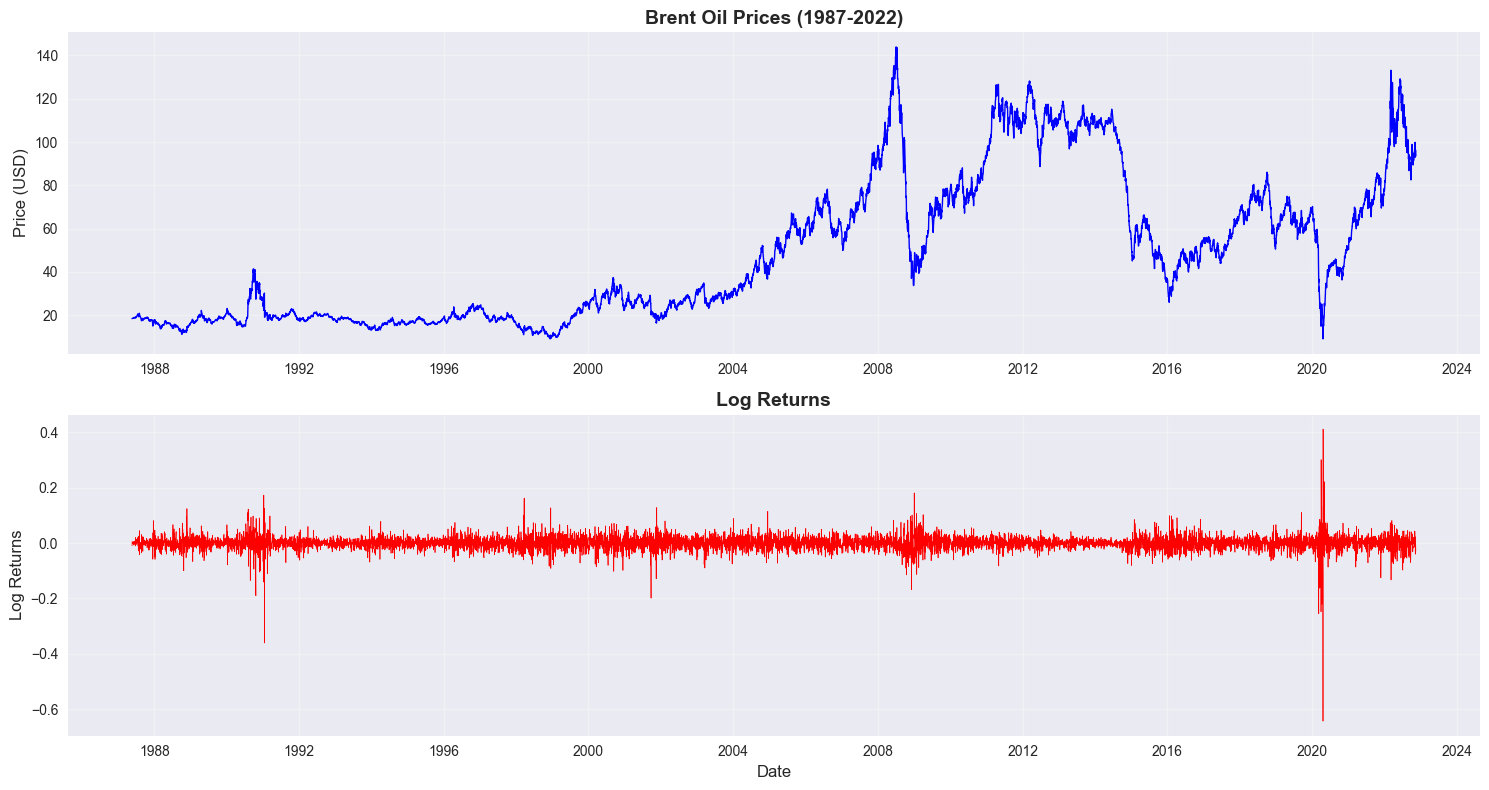

In [26]:
# Calculate log returns for change point analysis
df['log_returns'] = np.log(df['Price'] / df['Price'].shift(1))
df = df.dropna().reset_index(drop=True)

# Basic statistics of log returns
print("Log Returns Statistics:")
print(df['log_returns'].describe())

# Plot log returns
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Price'], linewidth=1, color='blue')
plt.title('Brent Oil Prices (1987-2022)', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['log_returns'], linewidth=0.5, color='red')
plt.title('Log Returns', fontsize=14, fontweight='bold')
plt.ylabel('Log Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Load Events Data

In [27]:
# Load events data
events_df = pd.read_csv('../../reports/events_timeline.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])
events_df = events_df.sort_values('Date').reset_index(drop=True)

print(f"Events dataset shape: {events_df.shape}")
print("\nKey Events:")
for _, event in events_df.iterrows():
    print(f"{event['Date'].strftime('%Y-%m-%d')}: {event['Event']} ({event['Category']})")

events_df.head()

Events dataset shape: (16, 6)

Key Events:
1987-10-19: Black Monday Stock Market Crash (Economic Crisis)
1990-08-02: Iraq Invasion of Kuwait (Geopolitical Conflict)
1991-01-17: Gulf War Begins (Geopolitical Conflict)
1997-07-02: Asian Financial Crisis Begins (Economic Crisis)
1998-12-10: Oil Price Reaches Historic Low (Market Event)
2001-09-11: 9/11 Terrorist Attacks (Geopolitical Conflict)
2003-03-20: Iraq War Begins (Geopolitical Conflict)
2008-07-03: Oil Price Reaches Historic High (Market Event)
2008-09-15: Lehman Brothers Bankruptcy (Economic Crisis)
2011-01-25: Arab Spring Begins (Geopolitical Conflict)
2014-06-01: OPEC Production Increase (OPEC Decision)
2016-11-30: OPEC Production Cut Agreement (OPEC Decision)
2020-03-11: COVID-19 Declared Pandemic (Economic Crisis)
2020-04-20: Oil Price Goes Negative (Market Event)
2022-02-24: Russia Invades Ukraine (Geopolitical Conflict)
2022-03-08: US Bans Russian Oil Imports (Economic Sanction)


,Date,Event,Category,Description,Expected_Impact,Data_Validation
0,1987-10-19,Black Monday Stock Market Crash,Economic Crisis,Global stock market crash affecting commodity ...,Negative,Price decline observed
1,1990-08-02,Iraq Invasion of Kuwait,Geopolitical Conflict,"Iraq invades Kuwait, leading to supply concerns",Positive,Price increase observed
2,1991-01-17,Gulf War Begins,Geopolitical Conflict,Operation Desert Storm begins,Positive,Price increase observed
3,1997-07-02,Asian Financial Crisis Begins,Economic Crisis,Currency crisis in Thailand spreads across Asia,Negative,Lowest price $9.10 in Dec 1998
4,1998-12-10,Oil Price Reaches Historic Low,Market Event,Oil prices hit $9.10 per barrel during the Asi...,Negative,Confirmed lowest price in the dataset


## 4. Identify Crisis Periods for Validation

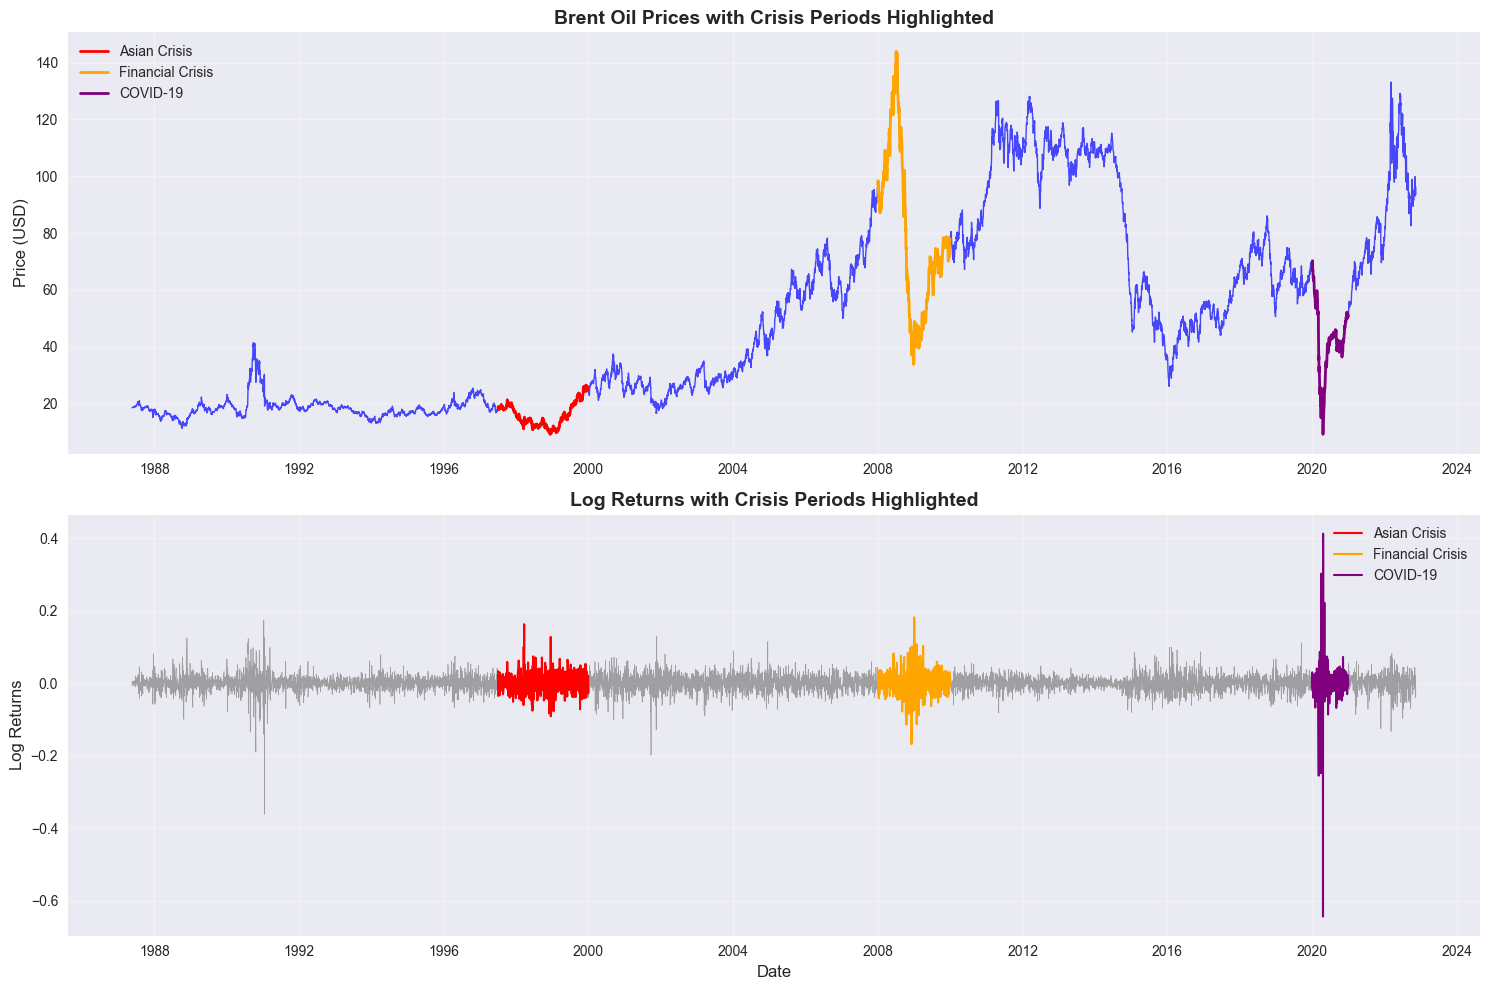

In [28]:
# Define major crisis periods for model validation
crisis_periods = {
    'Asian Crisis': {
        'start': '1997-07-01',
        'end': '1999-12-31',
        'description': 'Asian Financial Crisis - Lowest price $9.10'
    },
    'Financial Crisis': {
        'start': '2008-01-01',
        'end': '2009-12-31',
        'description': 'Global Financial Crisis - Highest price $143.95'
    },
    'COVID-19': {
        'start': '2020-01-01',
        'end': '2020-12-31',
        'description': 'COVID-19 Pandemic - Dramatic price collapse'
    }
}

# Plot crisis periods
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Price'], linewidth=1, color='blue', alpha=0.7)

colors = ['red', 'orange', 'purple']
for i, (crisis, period) in enumerate(crisis_periods.items()):
    start_date = pd.to_datetime(period['start'])
    end_date = pd.to_datetime(period['end'])
    
    # Filter data for crisis period
    crisis_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    if not crisis_data.empty:
        plt.plot(crisis_data['Date'], crisis_data['Price'], 
                linewidth=2, color=colors[i], label=crisis)

plt.title('Brent Oil Prices with Crisis Periods Highlighted', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['log_returns'], linewidth=0.5, color='gray', alpha=0.7)

for i, (crisis, period) in enumerate(crisis_periods.items()):
    start_date = pd.to_datetime(period['start'])
    end_date = pd.to_datetime(period['end'])
    
    crisis_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    if not crisis_data.empty:
        plt.plot(crisis_data['Date'], crisis_data['log_returns'], 
                linewidth=1.5, color=colors[i], label=crisis)

plt.title('Log Returns with Crisis Periods Highlighted', fontsize=14, fontweight='bold')
plt.ylabel('Log Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Quality Check for Change Point Analysis

Outliers detected: 432 (4.79%)


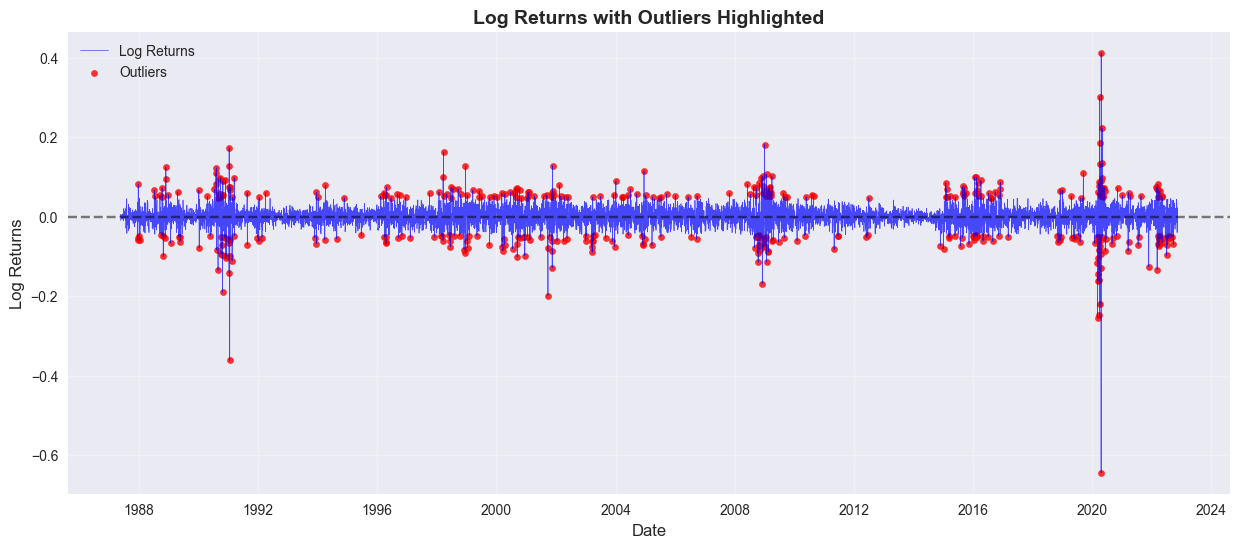


Extreme outliers (top 10 by absolute value):
2020-04-21: -0.6437
2020-04-22: 0.4120
1991-01-17: -0.3612
2020-04-02: 0.3016
2020-03-09: -0.2552
2020-04-01: -0.2483
2020-05-05: 0.2216
2020-04-09: -0.2205
2001-09-24: -0.1989
1990-10-22: -0.1902


In [29]:
# Check for outliers in log returns
Q1 = df['log_returns'].quantile(0.25)
Q3 = df['log_returns'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['log_returns'] < lower_bound) | (df['log_returns'] > upper_bound)]
print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

# Plot outliers
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['log_returns'], linewidth=0.5, color='blue', alpha=0.7, label='Log Returns')
plt.scatter(outliers['Date'], outliers['log_returns'], color='red', s=20, alpha=0.8, label='Outliers')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Log Returns with Outliers Highlighted', fontsize=14, fontweight='bold')
plt.ylabel('Log Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show extreme outliers
print("\nExtreme outliers (top 10 by absolute value):")
outliers['abs_log_returns'] = outliers['log_returns'].abs()
extreme_outliers = outliers.nlargest(10, 'abs_log_returns')
for _, row in extreme_outliers.iterrows():
    print(f"{row['Date'].strftime('%Y-%m-%d')}: {row['log_returns']:.4f}")

## 6. Prepare Data for PyMC Modeling

In [30]:
# Prepare data for PyMC modeling
# We'll use log returns for change point detection
log_returns = df['log_returns'].values
n_obs = len(log_returns)

print(f"Number of observations: {n_obs}")
print(f"Log returns mean: {log_returns.mean():.6f}")
print(f"Log returns std: {log_returns.std():.6f}")
print(f"Log returns min: {log_returns.min():.6f}")
print(f"Log returns max: {log_returns.max():.6f}")

# Check for any remaining NaN values
print(f"\nNaN values in log returns: {np.isnan(log_returns).sum()}")

# Save prepared data for next notebook
prepared_data = {
    'log_returns': log_returns,
    'dates': df['Date'].values,
    'prices': df['Price'].values,
    'n_obs': n_obs,
    'crisis_periods': crisis_periods,
    'events_df': events_df
}

print("\nData prepared successfully for Bayesian change point modeling!")

Number of observations: 9010
Log returns mean: 0.000179
Log returns std: 0.025531
Log returns min: -0.643699
Log returns max: 0.412023

NaN values in log returns: 0

Data prepared successfully for Bayesian change point modeling!


## Summary

This notebook has prepared the Brent oil prices data for Bayesian change point analysis:

1. **Data Loading**: Loaded and cleaned the Brent oil prices dataset
2. **Log Returns**: Calculated log returns for stationarity
3. **Events Data**: Loaded the 16 major events timeline
4. **Crisis Periods**: Identified three major crisis periods for validation
5. **Data Quality**: Checked for outliers and data integrity
6. **Model Preparation**: Prepared clean data for PyMC modeling

The data is now ready for the next notebook: **Bayesian Change Point Model Implementation**.